In [1]:
import os
import rasterio as rio                                                                                                                                                                                         
import tifffile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import csv
import pickle
from pathlib import Path
import torchvision.transforms as transforms
from PIL import ImageEnhance, Image
import geopandas as gpd
from shapely.geometry import Point

%matplotlib inline

def save_pickle(file, data):
    with open(file, 'wb') as f:
        pickle.dump(data, f)

        
def load_pickle(file):
    with open(file, 'rb') as f:
        return pickle.load(f)

In [2]:
df = pd.read_csv('filelist/cbna_final_w_covariates.csv', sep=',', low_memory=False, dtype={'labelset': str})

In [3]:
df.shape

(158292, 22)

## One-hot encoding

In [4]:
lis = df['labelset'].str.split(',').values.tolist()

In [5]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(lis)

In [6]:
len(mlb.classes_)

2522

In [7]:
#np.savetxt('datafile/classes.txt', mlb.classes_, delimiter=" ", fmt="%s")

In [7]:
classes = np.genfromtxt('datafile/classes.txt', dtype='str')
print(len(classes))

2522


## Get train and valtest split (0.8/0.2)

In [9]:
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from sklearn.utils import indexable, _safe_indexing
from sklearn.utils.validation import _num_samples
from sklearn.model_selection._split import _validate_shuffle_split
from itertools import chain

def multilabel_train_test_split(*arrays,
                                test_size=None,
                                train_size=None,
                                random_state=None,
                                shuffle=True,
                                stratify=None):
    """
    Train test split for multilabel classification. Uses the algorithm from: 
    'Sechidis K., Tsoumakas G., Vlahavas I. (2011) On the Stratification of Multi-Label Data'.
    """
    if stratify is None:
        return train_test_split(*arrays, test_size=test_size,train_size=train_size,
                                random_state=random_state, stratify=None, shuffle=shuffle)
    
    assert shuffle, "Stratified train/test split is not implemented for shuffle=False"
    
    n_arrays = len(arrays)
    arrays = indexable(*arrays)
    n_samples = _num_samples(arrays[0])
    n_train, n_test = _validate_shuffle_split(
        n_samples, test_size, train_size, default_test_size=0.25
    )
    cv = MultilabelStratifiedShuffleSplit(test_size=n_test, train_size=n_train, random_state=123)
    train, test = next(cv.split(X=arrays[0], y=stratify))

    return list(
        chain.from_iterable(
            (_safe_indexing(a, train), _safe_indexing(a, test)) for a in arrays
        )
    )

In [10]:
index_train, index_valtest, _ , _ = multilabel_train_test_split(df.index.values.reshape(-1,1), labels, stratify=labels, test_size=0.20)

In [11]:
train_df = df[df.index.isin(index_train.squeeze())]
valtest_df = df[df.index.isin(index_valtest.squeeze())]

In [12]:
#train_df.to_csv('datafile/train_w_covariates.csv', sep=',', encoding='utf-8', index=False)
#valtest_df.to_csv('datafile/valtest_w_covariates.csv', sep=',', encoding='utf-8', index=False)

In [13]:
train_labels = labels[index_train.squeeze()]
valtest_labels = labels[index_valtest.squeeze()]

## Get val and test split from valtest (0.5/0.5)

In [14]:
train_df.reset_index(drop=True, inplace=True)
valtest_df.reset_index(drop=True, inplace=True)

In [15]:
index_val, index_test, _ , _ = multilabel_train_test_split(valtest_df.index.values.reshape(-1,1), valtest_labels, stratify=valtest_labels, test_size=0.5)

In [16]:
val_df = valtest_df[valtest_df.index.isin(index_val.squeeze())]
test_df = valtest_df[valtest_df.index.isin(index_test.squeeze())]

In [17]:
#val_df.to_csv('datafile/val_w_covariates.csv', sep=',', encoding='utf-8', index=False)
#test_df.to_csv('datafile/test_w_covariates.csv', sep=',', encoding='utf-8', index=False)

In [18]:
val_labels = valtest_labels[index_val.squeeze()]
test_labels = valtest_labels[index_test.squeeze()]

## Create a 100-meter buffer for each test data

In [19]:
# Create GeoDataFrames for train and test set
train_gdf = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lat, lon in train_df[['x_l93','y_l93']].values], 
                                   crs="EPSG:2154")

test_gdf = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lat, lon in test_df[['x_l93','y_l93']].values], 
                                   crs="EPSG:2154")

In [21]:
test_gdf['buffer'] = test_gdf['geometry'].buffer(100)  
test_gdf.set_geometry('buffer', inplace=True)
joined = gpd.sjoin(train_gdf, test_gdf[['buffer']], predicate='within')

all_indices = [i for i in range(train_df.shape[0])]
indices = list(joined.index)
final_idx = list(set(all_indices) - set(indices))
train_modi_df = train_df.iloc[final_idx]

In [22]:
train_modi_df.shape

(98763, 22)

In [ ]:
#train_modi_df.to_csv('datafile/train_w_covariates_final.csv', sep=',', encoding='utf-8', index=False)

In [24]:
meta_features = ['LANDOLT_MOIST',
       'N_prct', 'pH', 'CN', 'TMeanY', 'TSeason', 'PTotY', 'PSeason', 'RTotY',
       'RSeason', 'AMPL', 'LENGTH', 'eauvive', 'clay', 'silt', 'sand', 'cv_alti']

In [25]:
m = torch.tensor(np.mean(train_modi_df[meta_features].values, axis=0)).float()
std = torch.tensor(np.std(train_modi_df[meta_features].values, axis=0)).float()

save_dict = {'mean': m, 'std': std}
#torch.save(save_dict, 'datafile/stats_meta_wolc.pth')

In [27]:
def get_label_count(df):
    classes = list(np.genfromtxt('datafile/classes.txt', dtype='str'))
    num_cls = len(classes)
    init_values = [0] * num_cls
    label_cnt = dict(zip(classes, init_values))

    labelset_arrays = df.labelset.values
    for i in range(len(labelset_arrays)):
        labelset = labelset_arrays[i].split(',')
        for label in labelset:
            label_cnt[label] += 1

    return label_cnt

In [29]:
label_cnt = get_label_count(train_modi_df)
print(np.max(np.array(list(label_cnt.values()))))

13857


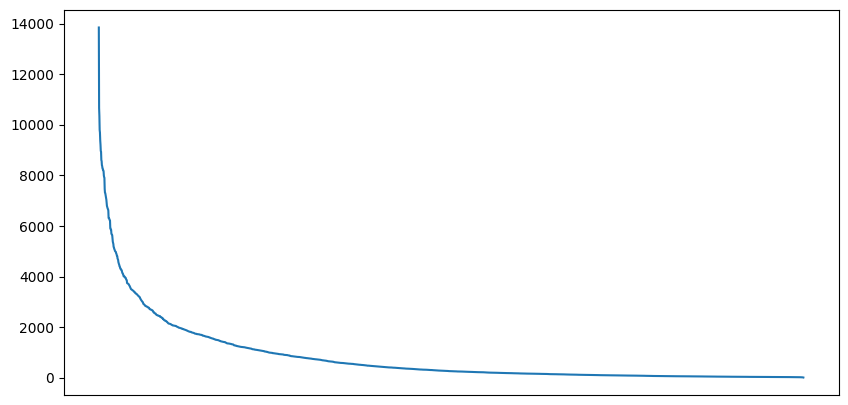

In [30]:
plt.figure(figsize=(10,5))
plt.plot(np.sort(np.array(list(label_cnt.values())))[::-1])
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.show()